In [3]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
from collections import Counter
import nltk; nltk.download('stopwords')
import matplotlib.pyplot as plt

## Loading the data

In [543]:
proverbs = pd.read_csv("input/proverbs.csv", index_col=0)
proverbs.shape

(134493, 4)

In [544]:
proverbs.sample(3)

,text,place,uri,collector
32671,"Νειος κλέφτης, γέρος κάλπης (ψεύτης)",Επτάνησος,http://hdl.handle.net/20.500.11853/286607,"Καββαδίας, Γεώργιος"
122629,Άκου γερόντου συμβουλή και παιδεμένου γνώση,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/197520,anonymous
15389,Ευτά ο κόσμος έχει τα κι' εμείς παθαίνομε dα,"Νάξος, Απείρανθος",http://hdl.handle.net/20.500.11853/229658,"Ζευγώλη – Γλέζου, Διαλεχτή"


In [545]:
proverbs[proverbs.text.str.contains("=")].sample().text

122349    Ανάβαλτος= ο δαίμων.
Name: text, dtype: object

In [546]:
# removing few definitions included
proverbs = proverbs[~proverbs.text.str.contains("=")]
proverbs.shape

(134106, 4)

In [547]:
print(f"{proverbs.shape[0] - proverbs.drop_duplicates().shape[0]} duplicates")

13875 duplicates


In [548]:
proverbs["area"] = proverbs.place.map(lambda x: x.split(",")[0])
proverbs.sample(3)

,text,place,uri,collector,area
32560,Ναν καλά κι ας είναι λίγα,Επτάνησος,http://hdl.handle.net/20.500.11853/289743,"Καββαδίας, Γεώργιος",Επτάνησος
108819,Άσκημε μου κι ασκημή μου τι θα πρωτοφάμε βράδυ;,"Κορινθία, Τρίκαλα",http://hdl.handle.net/20.500.11853/158146,"Σταματούλης, Ι. Π.",Κορινθία
4834,Δεν αξίζ' το gόπο,"Θράκη, Σαράντα Εκκλησίες",http://hdl.handle.net/20.500.11853/141410,"Βαφείδης, Θεολόγης Γ.",Θράκη


In [549]:
# number of proverbs with no information about the location 
len(proverbs[proverbs.area=='Άδηλου τόπου'].text.unique())

3698

# Geolocating

In [550]:
# geolocate to visualise the shared sayings
locations = proverbs.area.unique()
len(locations)

134

In [58]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="sayings.gr")
geolocs = {}
for loc in locations:
    # Avoiding polysemy by including "Greece" in the query
    location = geolocator.geocode(loc+ ", Ελλάδα") 
    if location:
        geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
    else:
        print (loc)

Άδηλου τόπου
Φθιώτιδα
Αδριανούπολη
Δυτική Μάνη
Καππαδοκία
Δαρδανέλλια (Ελλήσποντος)
Αλβανία
Φωκίδα
Ημαθία
Βοιωτία
Αερόπολη
Τριφυλία
Μπλάτση
Ανατολική Κρήτη
Ανατολική Θράκη
Ανδρίτσαινα Ολυμπίου
Δυτική Κρήτη
Στερεά Ελλάδα
Ναυπακτία
Δωδεκάνησα
Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)


In [479]:
# fixing some by hand
location = geolocator.geocode("Cyprus")
geolocs["Κύπρος"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Siteia")
geolocs["Ανατολική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Chania")
geolocs["Δυτική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Nafpaktia")
geolocs["Ναυπακτία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Lepenou")
geolocs["Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Cappadocia")
geolocs["Καππαδοκία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Imathia")
geolocs["Ημαθία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Boeotia")
geolocs["Βοιωτία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Edirne")
geolocs["Ανατολική Θράκη"] = {"lat":location.latitude, "lon":location.longitude}
geolocs["Αδριανούπολη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Phthiotis")
geolocs["Φθιώτιδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Andritsaina")
geolocs["Ανδρίτσαινα Ολυμπίου"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Dardanelles Strait")
geolocs["Δαρδανέλλια (Ελλήσποντος)"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Central Greece")
geolocs["Στερεά Ελλάδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Areopoli")
geolocs["Αερόπολη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Trifylia")
geolocs["Τριφυλία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Phocis")
geolocs["Φωκίδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("West Mani")
geolocs["Δυτική Μάνη"] = {"lat":location.latitude, "lon":location.longitude}

In [551]:
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs[proverbs.lon.notna()].shape

(125222, 7)

# The anonymous collector

In [552]:
unnamed = proverbs[proverbs.collector=="anonymous"]
named = proverbs[proverbs.collector!="anonymous"]
print(f'{unnamed.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


# Duplicates

In [553]:
print(f'{proverbs[proverbs.collector!="anonymous"].duplicated().sum()} duplicate proverbs from named collectors')

29 duplicate proverbs from named collectors


In [554]:
# the areas of the duplicates by named collectors
proverbs[(proverbs.collector!="anonymous")&(proverbs.duplicated())].area.unique()

array(['Κρήτη', 'Μικρά Ασία', 'Ήπειρος'], dtype=object)

In [555]:
# texts reported on multiple locations
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 3204 unique texts, 3204 exist in multiple areas


In [556]:
named.sample()

,text,place,uri,collector,area,lat,lon
99802,Ο λύκος κι αν εγέρασε κι άλλαξε το μαλλί του ο...,"Κεφαλληνία, Άσσος",http://hdl.handle.net/20.500.11853/277426,"Πατρικίου, Σταματία Σ.",Κεφαλληνία,38.237934,20.560883


In [557]:
# Exploring the areas of the duplicates, focusing on items by named collectors
grouping = named[named.lat.notna()&named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.apply(set)})
duplicates["place_num"] = duplicates.place.apply(len)
duplicates.sort_values(by="place_num", ascending=False)[:3]

,place,place_num
text,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κρήτη, Εύβοια, Κύμη, Αχαΐα, Πάτρα, Κοζάνη, Βό...",45
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Κρήτη, Εύβοια, Κύμη, Αχαΐα, Πάτρα, Θράκη, Σηλ...",28
Θεωρία επισκόπου και καρδιά μυλωνά,"{Κρήτη, Αχαΐα, Πάτρα, Αχαΐα, Καλάβρυτα, Μακεδο...",27


In [558]:
# finding the broader location
duplicates["area"] = duplicates.place.map(lambda x: {i.split(",")[0] for i in x})
duplicates["area_num"] = duplicates.area.apply(len)
duplicates.sort_values(by="area_num", ascending=False)[:3]

,place,place_num,area,area_num
text,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κρήτη, Εύβοια, Κύμη, Αχαΐα, Πάτρα, Κοζάνη, Βό...",45,"{Κρήτη, Φιλιππούπολη, Πήλιο, Ιωάννινα, Μικρά Α...",23
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Πέλλα, Γιαννιτσά, Αραβησσός, Σέρρες, Κοζάνη, ...",26,"{Κρήτη, Σέρρες, Πέλλα, Άνδρος, Φιλιππούπολη, Ι...",20
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Κρήτη, Εύβοια, Κύμη, Αχαΐα, Πάτρα, Θράκη, Σηλ...",28,"{Κρήτη, Μικρά Ασία, Εύβοια, Αδριανούπολη, Αχαΐ...",18


In [559]:
# ignore neighbours
duplicates = duplicates[duplicates.area_num>1]

In [560]:
# summarising it all in a dataframe
duplicates['latlon'] = duplicates.area.map(lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
                                                        for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.sample()

,place,place_num,area,area_num,latlon
text,,,,,
Όλο τ' αυγό στην πίτα;,"{Μάνη, Λακωνία}",2,"{Μάνη, Λακωνία}",2,"[(41.4097472, 26.4024952), (36.76027945, 22.79..."


In [561]:
duplicates.to_pickle("duplicates_geolocated.csv")

In [568]:
# visualising the dataframe (note that few are located in Italy, at Chiesa della Madona delle Neve)
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)
for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)
m.save("duplicates.html")
m

In [565]:
# computing the number of areas sharing proverbs with a target area
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 20


# Single-placed proverbs

In [567]:
# keeping single-placed proverbs
proverbs_sp = proverbs[~proverbs.text.duplicated(keep=False)]
proverbs_sp.sample(3)

,text,place,uri,collector,area,lat,lon
82937,"Δεν μ' έκαν' η μάννα μ' μια λαγάνα, να τρώη μι...",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/208344,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN
67680,Σαν τη βρακοζώνα του Μισελικούκου!,"Λευκάδα, Μεγανήσι, Κατωμέρι",http://hdl.handle.net/20.500.11853/151952,"Λουκάτος, Δημήτριος Σ.",Λευκάδα,38.706573,20.641709
93733,Τ' αμπέλι αγπά τη τσάππαν,"Κύπρος, Λευκωσία",http://hdl.handle.net/20.500.11853/156472,"Παναρέτος, Άνθιμος",Κύπρος,34.982302,33.145128


In [570]:
# keep aside single-placed proberbs from an unknown place
unlocated = "Άδηλου τόπου"
proverbs_sp_unk = proverbs_sp[proverbs_sp.place==unlocated]
print(f'{proverbs_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
proverbs_sp_unk.sample(3)

2752 proverbs from one place, whose name is not known.


,text,place,uri,collector,area,lat,lon
77470,"Τον λύκο τον βλέπουμε, τον τορό ζητάμε",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/186245,"Μέγας, Γ. Α.",Άδηλου τόπου,NaN,NaN
89127,"Το σκυλί που συνειθίση στο χασαπουλιό, δεν ξεσ...",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/265672,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN
82337,"Αποκοπή, αποκαή",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/155544,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN


In [572]:
# working with the rest
proverbs_sp = proverbs_sp[proverbs_sp.place!=unlocated]
print(f'{proverbs_sp.shape[0]} proverbs from one place with known place name')

98064 proverbs from one place with known place name


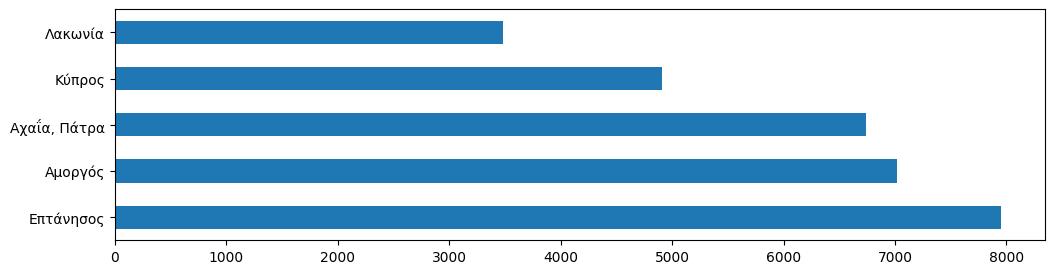

In [573]:
proverbs_sp.place.value_counts()[:5].plot.barh(figsize=(12,3));

In [530]:
freq_places = sayings_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(",")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html'); m

In [574]:
group_level = "area"
placed = proverbs_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


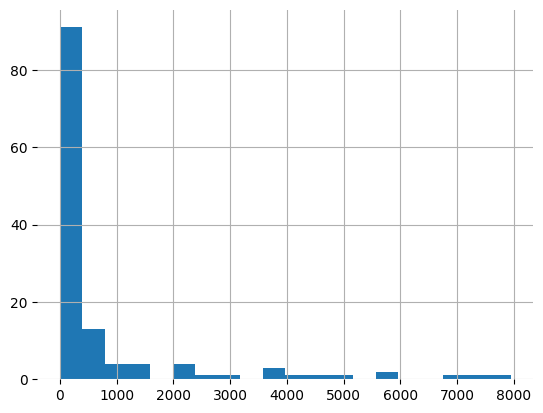

In [575]:
placed_pd.length.hist(bins=20);
sns.despine(left=True, bottom=True)

In [576]:
# places that are reported at least 1k times
common_places = placed_pd[placed_pd.length>1000].index
# filtering texts found on these places
common_sayings = proverbs_sp[proverbs_sp[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80837 proverbs from 23 places


In [577]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

In [578]:
# creating a balanced corpus
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

In [579]:
# one text per place
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
X = vect.fit_transform(long_texts)

In [580]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

In [581]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
τζα,0.000000,0.000000,0.000000,0.018439,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.440354,0.0,0.0,0.000000,0.000000,0.0,0.006423,0.000000,0.019658
μ μ,0.017984,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.240279,0.0,0.0,0.000000,0.008646,0.0,0.042053,0.078052,0.000000
ζαί,0.000000,0.005234,0.012788,0.000000,0.0,0.0,0.0,0.005933,0.013762,0.0,...,0.0,0.158624,0.0,0.0,0.006522,0.014528,0.0,0.000000,0.000000,0.000000


In [582]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}

In [507]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html'); m

In [583]:
geotfidf.to_csv("geotfidf.csv")

# Text spatial classification

In [585]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

In [280]:
balanced_corpus.sample(3)

,text,place,uri,collector,area,lat,lon
107803,Η γλώσσα θρέφει κ' η γλώσσα καταστρέφει,"Θράκη, Σουφλί",http://hdl.handle.net/20.500.11853/182196,"Σεϊτανίδης, Δημήτριος",Θράκη,40.846424,25.875938
930,Τα λόγια πουτέ δε σουμό δεν έχιν,Λέσβος,http://hdl.handle.net/20.500.11853/214859,"Αναγνώστου, Σ.",Λέσβος,39.175842,25.998913
65599,"Γενάρη μήνα κλάδιβι, φιγγάρι μη γυερύης",Λέσβος,http://hdl.handle.net/20.500.11853/163885,"Λουκάτος, Δημήτριος Σ.",Λέσβος,39.175842,25.998913


Learning an MLP operating on character n-grams to classify places

                 precision    recall  f1-score   support

        Ήπειρος       0.00      0.00      0.00        37
        Αιτωλία       0.39      0.56      0.46        59
        Αμοργός       0.27      0.30      0.29        47
Ανατολική Θράκη       0.19      0.24      0.21        49
        Αρκαδία       0.17      0.09      0.12        53
          Αχαΐα       0.29      0.28      0.29        53
      Επτάνησος       0.31      0.40      0.35        48
         Εύβοια       0.08      0.07      0.07        42
      Θεσπρωτία       0.13      0.15      0.14        48
          Θράκη       0.12      0.08      0.09        51
       Ιωάννινα       0.20      0.15      0.17        60
       Κάρπαθος       0.42      0.36      0.39        53
     Κεφαλληνία       0.27      0.26      0.26        47
          Κρήτη       0.23      0.23      0.23        52
         Κύπρος       0.73      0.83      0.77        52
         Λέσβος       0.37      0.40      0.38        55
        Λακωνία       0.06    

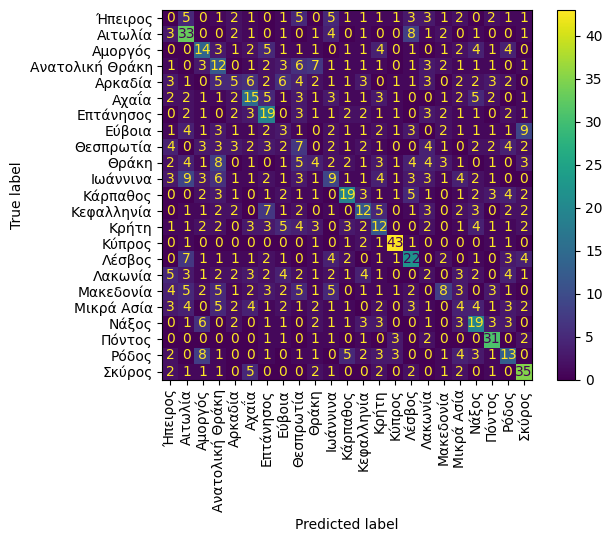

In [586]:
# text classification flat
train, test = train_test_split(balanced_corpus, test_size=0.1, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
locator = Pipeline([('vect', vect), ('clf', LogisticRegression())])
locator.fit(train.text.values, train.area.values)
txt_preds = locator.predict(test.text.values)
print(classification_report(test.area.values, txt_preds, zero_division=0))
ConfusionMatrixDisplay.from_estimator(locator, test.text.values, test.area.values, xticks_rotation='vertical');

# Classifying non-located proverbs

In [587]:
unseen_predictions = locator.predict(proverbs_sp_unk.text.values)
unseen_predictions_conf = locator.predict_proba(proverbs_sp_unk.text.values)
unseen_predicted_pd = pd.DataFrame({"text": proverbs_sp_unk.text, 
                                    "prediction": unseen_predictions, 
                                    "confidence": [max(x) for x in unseen_predictions_conf]})
unseen_predicted_pd.sort_values(by="confidence", ascending=False).head(10)

,text,prediction,confidence
117337,"Ανdάσ σου διούμ πκιάννε, τζ' ανdάθ θωρείς, μεν...",Κύπρος,0.717144
42157,"Έδωκαν πρόσωπον τον Αλήν, κ' εσκώθεν κ' εσ' εσ...",Πόντος,0.707654
99688,Το λόγον ατ δύο κ' εφτεάει,Πόντος,0.664796
97583,Αυτός είναι Ηρώδης,Αχαΐα,0.651637
89938,"Αρμάστου αρμάστου, τσαί dεpοί τωρεί dυο μέραι ...",Σκύρος,0.629346
77232,Αυτός είναι Παύλος,Αχαΐα,0.584798
119325,Αυτός είναι άμπακας,Αχαΐα,0.523409
103540,Αυτός είναι κλαψομάρτης,Αχαΐα,0.482568
42263,Ου Τούρκους πιάν' του λαγό (ή τουγ κλέφτ') μι ...,Αιτωλία,0.361688
89336,Του γαιδάρου μύθον έλεγαν κι αυτός τ' αυτιά το...,Αιτωλία,0.353848


In [590]:
unseen_predicted_pd.to_excel("proverbs_located.xlsx", index=False)
unseen_predicted_pd[unseen_predicted_pd.confidence>0.5].shape

(7, 3)

# Classifying multi-located proverbs

In [591]:
duplicated_predicted_pd = duplicates[duplicates.area_num>1]
duplicated_predicted_pd.insert(4, "prediction", locator.predict(duplicated_predicted_pd.index.values))
probs = locator.predict_proba(duplicated_predicted_pd.index.values)
duplicated_predicted_pd.insert(5, "confidence", probs.max(1))
duplicated_predicted_pd.reset_index().to_excel("sayings_duplicated_located.xlsx", index=False)
duplicated_predicted_pd.sort_values(by="confidence", ascending=False).head(20)

,place,place_num,area,area_num,prediction,confidence,latlon
text,,,,,,,
Αυτός είναι μη μου άπτου,"{Ιωάννινα, Νεγάδες, Αμοργός}",2,"{Ιωάννινα, Αμοργός}",2,Αχαΐα,0.546462,"[(39.6639818, 20.8522784), (36.85252415, 25.89..."
Αυτός είναι ανεμόμυλος,"{Μικρά Ασία, Κυδωνία, Ανατολική Θράκη, Αχαΐα, ...",3,"{Ανατολική Θράκη, Αχαΐα, Μικρά Ασία}",3,Αχαΐα,0.486252,"[(41.6759327, 26.5587225), (38.0692748, 21.872..."
Εδώκαν άτον πρόσωπον και θέλει και τ' αστάριν,"{Αδριανούπολη, Πόντος}",2,"{Αδριανούπολη, Πόντος}",2,Πόντος,0.429035,"[(41.6759327, 26.5587225), (40.0850088, 23.977..."
Μ' πήρι τ' αυτιά,"{Ήπειρος, Ζαγόρι, Ιωάννινα, Νεγάδες}",2,"{Ιωάννινα, Ήπειρος}",2,Αιτωλία,0.427555,"[(39.6639818, 20.8522784), (37.9574332, 23.710..."
Αυτός είνι κατέβα να φάμι,"{Λέσβος, Πλωμάρι, Σάμος, Μαραθόκαμπος}",2,"{Σάμος, Λέσβος}",2,Αιτωλία,0.399462,"[(37.72461615, 26.819291891109838), (39.175841..."
Αυτός είναι διάβολος με τα κέρατα,"{Αχαΐα, Πάτρα, Μικρά Ασία, Κύζικος, Πάνορμος}",2,"{Αχαΐα, Μικρά Ασία}",2,Αχαΐα,0.388505,"[(38.0692748, 21.87273042232539), (38.1846366,..."
Πίσου είνι του πουτήρ' μι τ' ρίγαν',"{Αιτωλία, Αμβρακιά, Αρκαδία, Γορτυνία, Λάστα}",2,"{Αρκαδία, Αιτωλία}",2,Αιτωλία,0.387943,"[(38.0368583, 23.6689264), (37.4204248, 24.947..."
Άσκουπους ου νους διπλός ου κόπους,"{Ιωάννινα, Νεγάδες, Ήπειρος, Δολιανά}",2,"{Ιωάννινα, Ήπειρος}",2,Αιτωλία,0.378696,"[(39.6639818, 20.8522784), (37.9574332, 23.710..."
Ένας νους κι' αυτός ρωμαίϊκος,"{Ήπειρος, Ζαγόρι, Βίτσα, Αδριανούπολη}",2,"{Αδριανούπολη, Ήπειρος}",2,Αιτωλία,0.353651,"[(41.6759327, 26.5587225), (37.9574332, 23.710..."


# Authorship analysis


In [346]:
#!git clone https://github.com/ipavlopoulos/lm
# training one model per area, by sampling proverbs of that area
# WARNING: not robust
from lm.markov.models import LM
models = {}
for area in train.area.unique():
    texts = train[train.area==area].sample(300).text.values
    models[area] = LM(gram="CHAR").train(" \n ".join(texts))
    
def ling_dist(proverb, models=models):
    entropy = {loc:[models[loc].cross_entropy(proverb)] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

loc, dists = ling_dist('κακό χωριό τα λίγα σπίτια')
dists.sort_values(by=0, ascending=True, axis=1)

,Επτάνησος,Ιωάννινα,Θεσπρωτία,Εύβοια,Ρόδος,Κρήτη,Λακωνία,Ανατολική Θράκη,Κεφαλληνία,Μικρά Ασία,...,Νάξος,Κύπρος,Σκύρος,Αχαΐα,Θράκη,Αιτωλία,Αμοργός,Λέσβος,Μακεδονία,Πόντος
0,2.880414,3.396508,3.633337,3.83149,4.172114,4.177863,4.326928,4.406372,4.433669,4.703101,...,4.955898,5.016818,5.163095,5.165631,5.305463,5.434768,5.657341,5.676162,5.844187,6.00563


# Regression on the coordinates
By training to predict lat and lon we can see how specific words push the prediction toward west/east and north/south.

In [593]:
# regression (lat/lon) - at the word level for efficiency
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
linear = Pipeline([('vect', vect), ('reg', LinearRegression()])
linear.fit(train.text.values, train[["lat", "lon"]].values)
txt_preds = linear.predict(test.text.values)

In [594]:
print(f'R2 (train): {linear.score(train.text, train[["lat", "lon"]].values):.3f}')
print(f'R2 (dev): {linear.score(dev.text, dev[["lat", "lon"]].values):.3f}')

R2 (train): 1.000
R2 (dev): -0.288


In [595]:
print(f"MAE lat/lon: {mean_absolute_error(test.lat.values, txt_preds[:, 0]):.2f} / {mean_absolute_error(test.lon.values, txt_preds[:, 1]):.2f}")

MAE lat/lon: 1.66 / 2.37


In [596]:
importance_pd = pd.DataFrame({"feature":linear["vect"].get_feature_names_out(), 
                              "lat": linear["reg"].coef_[0, :],
                              "lon": linear["reg"].coef_[1, :]})

In [597]:
# features pushing to the north (higher lat)
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
4735,", δυ",9.569894,0.167944
4342,' ο χ,9.553875,2.879341
10467,βγά,8.762701,-2.486703
18255,λν,8.283937,3.292455
7306,ίγ',7.987102,-4.021928


In [598]:
# features pushing to the south (lower lat)
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
12005,ε δυ,-12.278654,9.193040
20845,νιν,-12.005266,69.485322
10546,βκ,-9.421342,13.467250
31509,ό;,-9.387411,12.156638
27677,τάξη,-8.769197,0.822146


Some words (fatto, gui) reveal noise in the data, for example coming from explanatory comments. It can be cleaned by removing any comments with "=".

In [599]:
# features pushing to the east (higher lon)
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
20845,νιν,-12.005266,69.485322
15803,ιν,-3.950255,21.461502
7281,ί.,-3.023841,17.162439
7280,"ί, το",2.365644,15.239034
18618,μ μ,-5.072667,13.998856


In [600]:
# features pushing to the west (lower lon)
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
20846,νιν,4.971905,-31.556428
20245,νάκ,6.767821,-13.121305
15892,ιο κα,5.633386,-12.690313
15804,ιν,2.852011,-12.671352
20246,νάκι,4.238983,-12.074472


# Agglomerative clustering

Focusing on a single proverb to track its route:

```
input: proverb target, threshold e
output: the target's dendrogram
1. for proverb in proverbs:
2.   dist[proverb] = edit_distance(proverb, target)
3. sort(dist, ascending=True)
4. filtered = [p in dist if dist[p]<e] 
5. representations = TFIDF(filtered)
6. dendrogram = Ward(representations)
```

In [602]:
# using a target
target = "Γιάννης κερνάει και Γιάννης πίνει"
proverbs[(proverbs.text.str.contains(target))]

,text,place,uri,collector,area,lat,lon
2226,Γιάννης κερνάει και Γιάννης πίνει,Φιλιππούπολη,http://hdl.handle.net/20.500.11853/177233,"Αποστολίδης, Μύρτιλος Κ.",Φιλιππούπολη,39.632764,22.396523
47375,Γιάννης κερνάει και Γιάννης πίνει!,"Αχαΐα, Πάτρα",http://hdl.handle.net/20.500.11853/212183,"Κορύλλος, Χρήστος Π.",Αχαΐα,38.069275,21.872730
72955,Γιάννης κερνάει και Γιάννης πίνει,"Θεσσαλία, Τρίκαλα",http://hdl.handle.net/20.500.11853/211888,"Μαλαβάκη, Ελένη",Θεσσαλία,39.559419,21.684849
97372,Γιάννης κερνάει και Γιάννης πίνει,"Αχαΐα, Καλάβρυτα",http://hdl.handle.net/20.500.11853/161564,"Παπανδρέου, Γεώργιος",Αχαΐα,38.069275,21.872730


In [608]:
from Levenshtein import distance as lev
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
candidates.sample()

,text,place,uri,collector,area,lat,lon,lev
106769,Από μικρό κι από μουρλό μαθαίνεις την αλήθεια,"Θράκη, Αίνος",http://hdl.handle.net/20.500.11853/157680,Σαμίδης,Θράκη,40.846424,25.875938,36


In [609]:
# keeping ones whose distance is below a threshold
close_candidates = candidates[candidates.lev < 20]

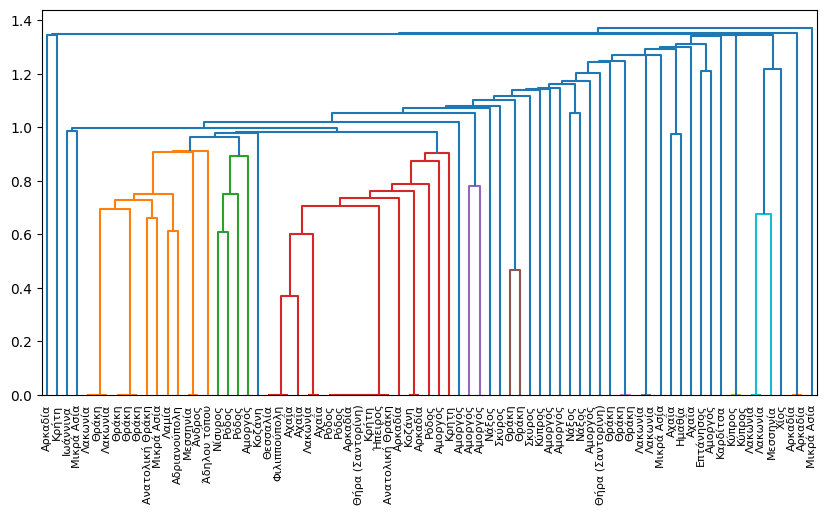

In [610]:
# hierarchical clustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
vec = TfidfVectorizer(analyzer="char", ngram_range=(3,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform(close_candidates.text.values)
#import sys; sys.setrecursionlimit(10000)
Z = linkage(X.toarray(), 'single')
plt.figure(figsize=(10, 5))
dendrogram(Z,
           orientation='top',
           labels=close_candidates.area.values,
           distance_sort='descending',
           show_leaf_counts=False,
           leaf_font_size=8.,
           show_contracted=True,
          )
plt.show();
clustering = fcluster(Z, t=1, criterion='distance')